<a href="https://colab.research.google.com/github/vinaybhardwaj1/multilabel_classifiers/blob/master/Multi_labelClassifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advance Machine Learning - Assignment 1 <br>
By - Vinay Bhardwaj(19200487)

Contents :
1. BinaryRelevanceClassifier - Implementation of multi-label classifier using binary relevance technique. This classifier takes 2 parameters, a base classifier of Classifier type and a boolean flag to specify the use of undersampling on imbalanced classes.

2. ChaningClassifier - Implementation of multi-label classifier using classifier chaining technique. This classifier takes one parameter, a base classifier of Classifier type.

3. Metric Definition - Evaluation metric for created multi-label classifiers.

4. Testing and Predictions - Use of yeast dataset to evaluate performances of our created classifiers using different base classifiers.

5. Conclusion - Final results of tests and inferences from the results.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import random
from joblib import Parallel, delayed
from sklearn.base import clone
from sklearn.datasets import fetch_openml

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import time


%matplotlib inline
#%qtconsole

## BinaryRelevanceClassifier

In [0]:
from sklearn.utils import resample

# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class BinaryRelevanceMLClassifier(BaseEstimator, ClassifierMixin):
  """The	binary relevance classifier is a	multi-label	classification algorithm in	which	individual	binary	base classifiers	are	
      implemented for	each	label.	This	uses	a	one-vs-all	approach	to	generate the	training	sets for	each	base classifier.

    Parameters
    ----------
    classifier, required (default = None)
      The base classifier to be used on multi-label data 
    use_under_sampling bool, optional (default = False)
      Flag to specify the use of undersampling on each label.

    Attributes
    ----------
    classes_ : dict 
        A dictionary of classes for each label.
    classifiers_ : dict
        A dictionary of the classifier for each label.
    num_labels_ : int
        Number of labels.
        
    Notes
    -----
    

    See also
    --------
    
    ----------

    """

    # Constructor for the classifier object
    def __init__(self,classifier = None,use_under_sampling = False):
        self.classifier = classifier # delfault distance function = euclidean
        self.use_under_sampling = use_under_sampling 

    # The fit function to train a classifier
    def fit(self, X, y):
        if self.classifier == None:
          return "No classifier specified"
        
        # Check that X and y have correct shape
        yn = {}
        uniques = {}
        counts = {}
        classifiers = {}
        Xn = {}
        for i in range(y.shape[1]):
          # Check shape of X and y
          Xn["X{}".format(i)], yn["y{}".format(i)] = check_X_y(X, y[:,i])
          # Count the number of occurrences of each class in the target vector (uses mupy unique function that returns a list of unique values and their counts)
          uniques["unique{}".format(i)], counts["count{}".format(i)] = np.unique(y[:,i], return_counts=True)
          

          # Use of under sampling
          if(self.use_under_sampling == True) :
            min_samples = min(counts["count{}".format(i)])

            # Undersampling imbalanced labels - uses sklearn.resample method to reduce samples
            for u,c in zip(uniques["unique{}".format(i)], counts["count{}".format(i)]):
              if c != min_samples:
                tempX = np.delete(Xn["X{}".format(i)],np.where(yn["y{}".format(i)] == u)[0],0 )
                tempX_new = resample(Xn["X{}".format(i)][yn["y{}".format(i)] == u],replace=True,n_samples=min_samples) # resampling to minimum samples for descriptive features
                Xn["X{}".format(i)] = np.append(tempX,tempX_new,axis=0)

                tempy = np.delete(yn["y{}".format(i)],np.where(yn["y{}".format(i)] == u)[0],0 )
                tempy_new = resample(yn["y{}".format(i)][yn["y{}".format(i)] == u],replace=True,n_samples=min_samples) # for labels
                yn["y{}".format(i)] = np.append(tempy,tempy_new,axis=0)
          
          # Create new classifier for each label
          classifiers["classifier{}".format(i)] = clone(self.classifier).fit(Xn["X{}".format(i)],yn["y{}".format(i)])# fitting classifiers
        
        # Store the classes seen during fit
        self.classes_ = uniques
        
        # Store the number of labels
        self.num_labels_ = y.shape[1]

        # Store the all the classifiers
        self.classifiers_ = classifiers
        
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):

        # Check is fit had been called by confirming that the distributions_ dictionary has been set up
        check_is_fitted(self, ['classifiers_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)

        predictions = []
        for i in range(self.num_labels_):
          predictions.append([])
          predictions[i] = self.classifiers_["classifier{}".format(i)].predict(X)

        predictions = np.transpose(predictions)
            
        return np.array(predictions)
    
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):

        # Check is fit had been called by confirming that the distributions_ dictionary has been set up
        check_is_fitted(self, ['classifiers_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        predic_proba = []
        for i in range(self.num_labels_):
          predic_proba.append([])
          predic_proba[i] = self.classifiers_["classifier{}".format(i)].predict_proba(X)

        predic_proba = np.transpose(predic_proba)
            
        return predic_proba

## ChaningClassifier

In [0]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class ChaningClassifier(BaseEstimator, ClassifierMixin):
    """The classifier	chains algorithm	is an	effective	multi-label	classification	algorithm	that	takes	advantage	of	
    label	associations.	A	classifier	chain	model generates	a	chain	of	binary	
    classifiers each	of	predicts	the	presence	or	absence of	a	specific	label.	The	
    in	input	to	each	classifier	in	the	chain,	however,	includes	the	original	
    descriptive	features	plus	the	outputs	of	the	classifiers so	far	in	the	chain.	
    This	allows	label	associations to	be	taken	into	account. Implement	the	classifier	chains	algorithm.

    Parameters
    ----------
    classifier, required (default = None)
      The base classifier to be used on multi-label data 

    Attributes
    ----------
    classes_ : dict 
        A dictionary of classes for each label.
    classifiers_ : dict
        A dictionary of the classifier for each label.
    num_labels_ : int
        Number of labels.
        
    Notes
    -----
    

    See also
    --------
    
    ----------

    """

    # Constructor for the classifier object
    def __init__(self,classifier = None):
        self.classifier = classifier # delfault classifier = None 

    # The fit function to train a classifier
    def fit(self, X, y):
        if self.classifier == None:
          return "No classifier specified"
        
        # Check that X and y have correct shape
        yn = {}
        uniques = {}
        counts = {}
        classifiers = {}
        Xn = {}
        for i in range(y.shape[1]):
          # Check shape of X and y
          Xn["X{}".format(i)], yn["y{}".format(i)] = check_X_y(X, y[:,i])
          
          # Count the number of occurrences of each class in the target vector 
          #(uses numpy unique function that returns a list of unique values and their counts)
          uniques["unique{}".format(i)], counts["count{}".format(i)] = np.unique(y[:,i], return_counts=True)
          
          # Re-defining X by appending new column of y
          if (i == 0):
            Xn_ = Xn["X{}".format(i)]
          else:
            Xn_ = np.hstack((Xn_, np.atleast_2d(y[:,i-1]).T))
          
          # Create new classifier for each label
          classifiers["classifier{}".format(i)] = clone(self.classifier).fit(Xn_,yn["y{}".format(i)]) # fitting classifiers
        
        # Store the classes seen during fit
        self.classes_ = uniques
        
        # Store the number of labels
        self.num_labels_ = y.shape[1]

        # Store the all the classifiers
        self.classifiers_ = classifiers
        
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):

        # Check is fit had been called by confirming that the distributions_ dictionary has been set up
        check_is_fitted(self, ['classifiers_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)

        predictions = []
        for i in range(self.num_labels_):

          # Appending predictions to X for next prediction
          if (i == 0):
            Xn_ = X
          else:
            Xn_ = np.hstack((Xn_, np.atleast_2d(predictions[i-1]).T))

          predictions.append([])
          predictions[i] = self.classifiers_["classifier{}".format(i)].predict(Xn_)

        predictions = np.transpose(predictions)
            
        return np.array(predictions)
    
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):

        # Check is fit had been called by confirming that the distributions_ dictionary has been set up
        check_is_fitted(self, ['classifiers_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        predic_proba = []
        for i in range(self.num_labels_):

          # Appending predictions to X for next prediction
          if (i == 0):
            Xn_ = X
          else:
            Xn_ = np.hstack((Xn_, np.atleast_2d(predictions[i-1]).T))

          predic_proba.append([])
          predic_proba[i] = self.classifiers_["classifier{}".format(i)].predict_proba(X)

        predic_proba = np.transpose(predic_proba)
            
        return predic_proba

## Evaluation Metrics <br>
We will use standard evaluation metrics - accuracy and f1-score and modify to create functions which can be used on multi-label data. Approach taken is individually calculating the metric for each label and then returning the mean measure of all the labels.

In [0]:
def multilabel_mean_accuracy(y_actual,y_predicted):
  accuracy = []
  for i in range(y_actual.shape[1]):
    accuracy.append(metrics.accuracy_score(y_actual[:,i], y_predicted[:,i]))
  return np.mean(accuracy)

def multilabel_mean_f1score(y_actual,y_predicted):
  f1_score = []
  for i in range(y_actual.shape[1]):
    f1_score.append(metrics.f1_score(y_actual[:,i], y_predicted[:,i]))
  return np.mean(f1_score)

## Testing and predictions

Now that we have created out classifiers we will import 'yeast' dataset and test our classifiers on this dataset.Test metrics use will be multilabel_mean_accuracy and multilabel_mean_f1score defined earlier.

In [0]:
X, Y = fetch_openml('yeast', version=4, return_X_y=True)
Y = Y == 'TRUE'
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2,random_state=0)

In [0]:
X

array([[ 0.004168, -0.170975, -0.156748, ..., -0.018312,  0.030126,
         0.124722],
       [-0.103956,  0.011879, -0.098986, ..., -0.041471, -0.079758,
         0.017161],
       [ 0.509949,  0.401709,  0.293799, ...,  0.02671 , -0.066565,
        -0.122352],
       ...,
       [ 0.082526, -0.095571, -0.022019, ..., -0.066957,  0.260121,
        -0.125303],
       [-0.13083 ,  0.008868, -0.009457, ..., -0.122332, -0.022453,
         0.001953],
       [-0.171578, -0.066536,  0.168206, ..., -0.083342, -0.063135,
         0.01881 ]])

In [0]:
Y_train

array([[ True,  True, False, ...,  True,  True, False],
       [False,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True, False],
       [False, False,  True, ...,  True,  True, False],
       [ True,  True,  True, ..., False, False, False]])

(A)Trying BinaryRelevanceMLClassifier with 1) DTrees, 2) GaussianNB and 3) KNN (Keeping under_sampling as False)

In [0]:
result_df1 = pd.DataFrame(columns=['Base Classifier', 'Accuracy', 'F1-Score'])

In [105]:
br = BinaryRelevanceMLClassifier(classifier=DecisionTreeClassifier())
br.fit(X_train,Y_train)

BinaryRelevanceMLClassifier(classifier=DecisionTreeClassifier(ccp_alpha=0.0,
                                                              class_weight=None,
                                                              criterion='gini',
                                                              max_depth=None,
                                                              max_features=None,
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                              min_samples_split=2,
                                                              min_weight_fraction_leaf=0.0,
                                                              presort='deprecated',
   

In [0]:
y_pred = br.predict(X_test)
result_df1.loc[0] = ['DTree',multilabel_mean_accuracy(Y_test,y_pred),multilabel_mean_f1score(Y_test,y_pred)]
print('Accuracy : {0:.2f} F1 Score : {1:.2f}'.format(result_df1['Accuracy'][0],result_df1['F1-Score'][0]))
print('Classification Report \n',metrics.classification_report(Y_test,y_pred))

Accuracy : 0.73 F1 Score : 0.38
Classification Report 
               precision    recall  f1-score   support

           0       0.51      0.50      0.50       163
           1       0.56      0.50      0.53       222
           2       0.53      0.51      0.52       183
           3       0.48      0.50      0.49       153
           4       0.57      0.48      0.52       155
           5       0.40      0.36      0.38       128
           6       0.27      0.29      0.28        83
           7       0.26      0.24      0.25        97
           8       0.00      0.00      0.00        39
           9       0.13      0.12      0.12        50
          10       0.16      0.16      0.16        50
          11       0.75      0.76      0.76       353
          12       0.75      0.79      0.77       350
          13       0.00      0.00      0.00         7

   micro avg       0.55      0.54      0.54      2033
   macro avg       0.38      0.37      0.38      2033
weighted avg       0.54 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
br = BinaryRelevanceMLClassifier(classifier=GaussianNB())
br.fit(X_train,Y_train)

BinaryRelevanceMLClassifier(classifier=GaussianNB(priors=None,
                                                  var_smoothing=1e-09),
                            use_under_sampling=False)

In [0]:
y_pred = br.predict(X_test)
result_df1.loc[1] = ['GaussianNB',multilabel_mean_accuracy(Y_test,y_pred),multilabel_mean_f1score(Y_test,y_pred)]
print('Accuracy : {0:.2f} F1 Score : {1:.2f}'.format(result_df1['Accuracy'][1],result_df1['F1-Score'][1]))
print('Classification Report \n',metrics.classification_report(Y_test,y_pred))

Accuracy : 0.69 F1 Score : 0.44
Classification Report 
               precision    recall  f1-score   support

           0       0.62      0.67      0.65       163
           1       0.55      0.68      0.61       222
           2       0.57      0.76      0.65       183
           3       0.50      0.57      0.53       153
           4       0.56      0.52      0.54       155
           5       0.40      0.54      0.46       128
           6       0.29      0.58      0.39        83
           7       0.28      0.51      0.36        97
           8       0.09      0.26      0.13        39
           9       0.15      0.38      0.22        50
          10       0.10      0.24      0.14        50
          11       0.78      0.65      0.71       353
          12       0.78      0.64      0.70       350
          13       0.00      0.00      0.00         7

   micro avg       0.49      0.60      0.54      2033
   macro avg       0.41      0.50      0.44      2033
weighted avg       0.57 

In [0]:
br = BinaryRelevanceMLClassifier(classifier=KNeighborsClassifier(n_neighbors=6))
br.fit(X_train,Y_train)

BinaryRelevanceMLClassifier(classifier=KNeighborsClassifier(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=6, p=2,
                                                            weights='uniform'),
                            use_under_sampling=False)

In [0]:
y_pred = br.predict(X_test)
result_df1.loc[2] = ['KNN',multilabel_mean_accuracy(Y_test,y_pred),multilabel_mean_f1score(Y_test,y_pred)]
print('Accuracy : {0:.2f} F1 Score : {1:.2f}'.format(result_df1['Accuracy'][2],result_df1['F1-Score'][2]))
print('Classification Report \n',metrics.classification_report(Y_test,y_pred))

Accuracy : 0.79 F1 Score : 0.39
Classification Report 
               precision    recall  f1-score   support

           0       0.76      0.37      0.50       163
           1       0.63      0.44      0.51       222
           2       0.59      0.49      0.54       183
           3       0.64      0.49      0.55       153
           4       0.79      0.46      0.58       155
           5       0.80      0.27      0.41       128
           6       0.60      0.14      0.23        83
           7       0.46      0.12      0.20        97
           8       1.00      0.03      0.05        39
           9       0.57      0.08      0.14        50
          10       0.38      0.06      0.10        50
          11       0.75      0.86      0.80       353
          12       0.75      0.85      0.80       350
          13       0.00      0.00      0.00         7

   micro avg       0.71      0.52      0.60      2033
   macro avg       0.62      0.33      0.39      2033
weighted avg       0.69 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


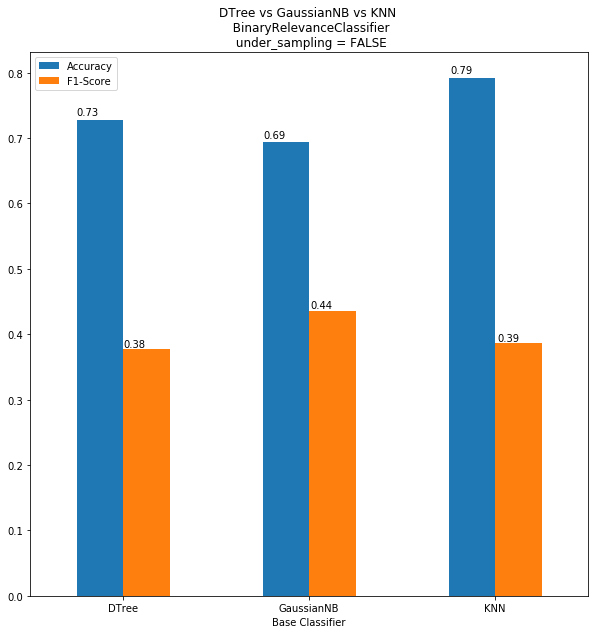

In [0]:
result_df1 = result_df1.set_index(['Base Classifier'])
ax = result_df1.plot.bar(rot=0,title="DTree vs GaussianNB vs KNN \n  BinaryRelevanceClassifier \n under_sampling = FALSE",figsize=(10,10))
ax.legend(loc=2)
for p in ax.patches:
    ax.annotate("{0:.2f}".format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.01))

(B) Trying BinaryRelevanceMLClassifier with 1) DTrees, 2) GaussianNB and 3) KNN <br> <b>(Keeping under_sampling as True)</b>


In [0]:
result_df2 = pd.DataFrame(columns=['Base Classifier', 'Accuracy', 'F1-Score'])

In [0]:
# Descision Tree
br = BinaryRelevanceMLClassifier(classifier=DecisionTreeClassifier(),use_under_sampling=True)
br.fit(X_train,Y_train)

BinaryRelevanceMLClassifier(classifier=DecisionTreeClassifier(ccp_alpha=0.0,
                                                              class_weight=None,
                                                              criterion='gini',
                                                              max_depth=None,
                                                              max_features=None,
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                              min_samples_split=2,
                                                              min_weight_fraction_leaf=0.0,
                                                              presort='deprecated',
   

In [0]:
y_pred = br.predict(X_test)
result_df2.loc[0] = ['DTree',multilabel_mean_accuracy(Y_test,y_pred),multilabel_mean_f1score(Y_test,y_pred)]
print('Accuracy : {0:.2f} F1 Score : {1:.2f}'.format(result_df2['Accuracy'][0],result_df2['F1-Score'][0]))
print('Classification Report \n',metrics.classification_report(Y_test,y_pred))

Accuracy : 0.56 F1 Score : 0.40
Classification Report 
               precision    recall  f1-score   support

           0       0.44      0.66      0.53       163
           1       0.49      0.60      0.54       222
           2       0.50      0.64      0.56       183
           3       0.44      0.69      0.54       153
           4       0.44      0.65      0.53       155
           5       0.33      0.64      0.44       128
           6       0.22      0.61      0.32        83
           7       0.24      0.62      0.35        97
           8       0.09      0.59      0.16        39
           9       0.13      0.62      0.21        50
          10       0.12      0.52      0.19        50
          11       0.79      0.55      0.65       353
          12       0.78      0.46      0.58       350
          13       0.03      1.00      0.05         7

   micro avg       0.36      0.59      0.44      2033
   macro avg       0.36      0.63      0.40      2033
weighted avg       0.52 

In [0]:
# Gaussian Naive Bayes
br = BinaryRelevanceMLClassifier(classifier=GaussianNB(),use_under_sampling=True)
br.fit(X_train,Y_train)

BinaryRelevanceMLClassifier(classifier=GaussianNB(priors=None,
                                                  var_smoothing=1e-09),
                            use_under_sampling=True)

In [0]:
y_pred = br.predict(X_test)
result_df2.loc[1] = ['GaussianNB',multilabel_mean_accuracy(Y_test,y_pred),multilabel_mean_f1score(Y_test,y_pred)]
print('Accuracy : {0:.2f} F1 Score : {1:.2f}'.format(result_df2['Accuracy'][1],result_df2['F1-Score'][1]))
print('Classification Report \n',metrics.classification_report(Y_test,y_pred))

Accuracy : 0.61 F1 Score : 0.44
Classification Report 
               precision    recall  f1-score   support

           0       0.59      0.69      0.64       163
           1       0.54      0.71      0.61       222
           2       0.57      0.77      0.66       183
           3       0.48      0.58      0.52       153
           4       0.54      0.57      0.55       155
           5       0.37      0.66      0.47       128
           6       0.28      0.75      0.41        83
           7       0.28      0.67      0.39        97
           8       0.10      0.64      0.17        39
           9       0.13      0.52      0.21        50
          10       0.12      0.56      0.20        50
          11       0.79      0.51      0.62       353
          12       0.79      0.51      0.62       350
          13       0.02      0.71      0.05         7

   micro avg       0.40      0.61      0.48      2033
   macro avg       0.40      0.63      0.44      2033
weighted avg       0.56 

In [0]:
# KNN
br = BinaryRelevanceMLClassifier(classifier=KNeighborsClassifier(6),use_under_sampling=True)
br.fit(X_train,Y_train)

BinaryRelevanceMLClassifier(classifier=KNeighborsClassifier(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=6, p=2,
                                                            weights='uniform'),
                            use_under_sampling=True)

In [0]:
y_pred = br.predict(X_test)
result_df2.loc[2] = ['KNN',multilabel_mean_accuracy(Y_test,y_pred),multilabel_mean_f1score(Y_test,y_pred)]
print('Accuracy : {0:.2f} F1 Score : {1:.2f}'.format(result_df2['Accuracy'][2],result_df2['F1-Score'][2]))
print('Classification Report \n',metrics.classification_report(Y_test,y_pred))

Accuracy : 0.66 F1 Score : 0.44
Classification Report 
               precision    recall  f1-score   support

           0       0.58      0.62      0.60       163
           1       0.56      0.55      0.55       222
           2       0.58      0.62      0.60       183
           3       0.52      0.59      0.55       153
           4       0.57      0.63      0.60       155
           5       0.42      0.54      0.47       128
           6       0.29      0.55      0.38        83
           7       0.30      0.54      0.39        97
           8       0.13      0.59      0.21        39
           9       0.17      0.44      0.24        50
          10       0.16      0.52      0.24        50
          11       0.83      0.48      0.61       353
          12       0.81      0.51      0.63       350
          13       0.03      0.57      0.05         7

   micro avg       0.45      0.55      0.50      2033
   macro avg       0.42      0.55      0.44      2033
weighted avg       0.59 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


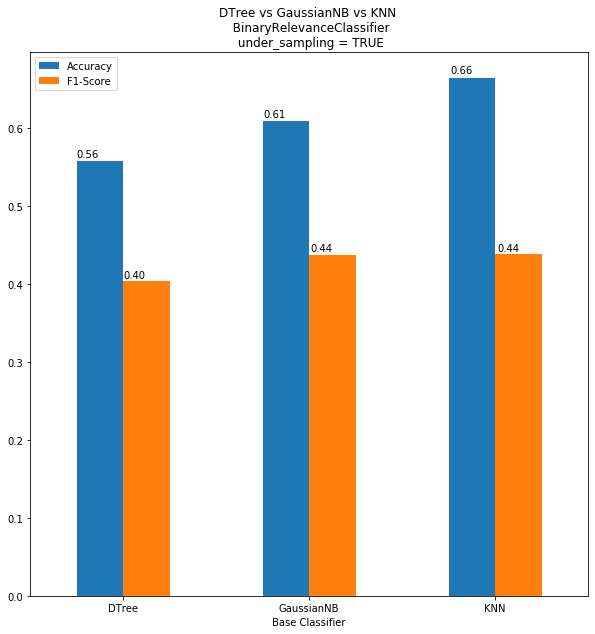

In [0]:
result_df2 = result_df2.set_index(['Base Classifier'])
ax = result_df2.plot.bar(rot=0,title="DTree vs GaussianNB vs KNN \n  BinaryRelevanceClassifier \n under_sampling = TRUE",figsize=(10,10))
ax.legend(loc=2)
for p in ax.patches:
    ax.annotate("{0:.2f}".format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.01))

(C) Trying ChaningClassifier with 1) DTrees, 2) GaussianNB and 3) KNN 

In [0]:
result_df3 = pd.DataFrame(columns=['Base Classifier', 'Accuracy', 'F1-Score'])

In [0]:
# DecisionTreeClassifier
cc = ChaningClassifier(classifier = DecisionTreeClassifier())
cc = cc.fit(X_train,Y_train)

In [0]:
y_pred = cc.predict(X_test)
result_df3.loc[0] = ['DTree',multilabel_mean_accuracy(Y_test,y_pred),multilabel_mean_f1score(Y_test,y_pred)]
print('Accuracy : {0:.2f} F1 Score : {1:.2f}'.format(result_df3['Accuracy'][0],result_df3['F1-Score'][0]))
print('Classification Report \n',metrics.classification_report(Y_test,y_pred))

Accuracy : 0.72 F1 Score : 0.37
Classification Report 
               precision    recall  f1-score   support

           0       0.51      0.51      0.51       163
           1       0.51      0.55      0.53       222
           2       0.47      0.56      0.51       183
           3       0.48      0.55      0.51       153
           4       0.50      0.46      0.48       155
           5       0.40      0.39      0.40       128
           6       0.28      0.24      0.26        83
           7       0.26      0.24      0.25        97
           8       0.13      0.13      0.13        39
           9       0.06      0.06      0.06        50
          10       0.07      0.08      0.08        50
          11       0.74      0.78      0.76       353
          12       0.73      0.77      0.75       350
          13       0.00      0.00      0.00         7

   micro avg       0.53      0.55      0.54      2033
   macro avg       0.37      0.38      0.37      2033
weighted avg       0.52 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
# GaussianNB
cc = ChaningClassifier(classifier = GaussianNB())
cc = cc.fit(X_train,Y_train)

In [0]:
y_pred = cc.predict(X_test)
result_df3.loc[1] = ['GaussianNB',multilabel_mean_accuracy(Y_test,y_pred),multilabel_mean_f1score(Y_test,y_pred)]
print('Accuracy : {0:.2f} F1 Score : {1:.2f}'.format(result_df3['Accuracy'][1],result_df3['F1-Score'][1]))
print('Classification Report \n',metrics.classification_report(Y_test,y_pred))

Accuracy : 0.68 F1 Score : 0.43
Classification Report 
               precision    recall  f1-score   support

           0       0.62      0.67      0.65       163
           1       0.58      0.69      0.63       222
           2       0.56      0.73      0.64       183
           3       0.48      0.58      0.52       153
           4       0.60      0.51      0.55       155
           5       0.45      0.48      0.47       128
           6       0.28      0.48      0.35        83
           7       0.28      0.43      0.34        97
           8       0.10      0.28      0.14        39
           9       0.15      0.48      0.23        50
          10       0.11      0.42      0.18        50
          11       0.77      0.60      0.67       353
          12       0.77      0.60      0.67       350
          13       0.00      0.00      0.00         7

   micro avg       0.47      0.58      0.52      2033
   macro avg       0.41      0.50      0.43      2033
weighted avg       0.57 

In [0]:
# KNeighborsClassifier
cc = ChaningClassifier(classifier = KNeighborsClassifier(6))
cc = cc.fit(X_train,Y_train)

In [0]:
y_pred = cc.predict(X_test)
result_df3.loc[2] = ['KNN',multilabel_mean_accuracy(Y_test,y_pred),multilabel_mean_f1score(Y_test,y_pred)]
print('Accuracy : {0:.2f} F1 Score : {1:.2f}'.format(result_df3['Accuracy'][2],result_df3['F1-Score'][2]))
print('Classification Report \n',metrics.classification_report(Y_test,y_pred))

Accuracy : 0.76 F1 Score : 0.39
Classification Report 
               precision    recall  f1-score   support

           0       0.76      0.37      0.50       163
           1       0.66      0.38      0.49       222
           2       0.61      0.43      0.50       183
           3       0.57      0.52      0.54       153
           4       0.59      0.57      0.58       155
           5       0.49      0.36      0.41       128
           6       0.30      0.23      0.26        83
           7       0.33      0.22      0.26        97
           8       0.25      0.03      0.05        39
           9       0.19      0.18      0.18        50
          10       0.12      0.12      0.12        50
          11       0.74      0.83      0.78       353
          12       0.74      0.83      0.78       350
          13       0.00      0.00      0.00         7

   micro avg       0.62      0.53      0.57      2033
   macro avg       0.45      0.36      0.39      2033
weighted avg       0.60 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


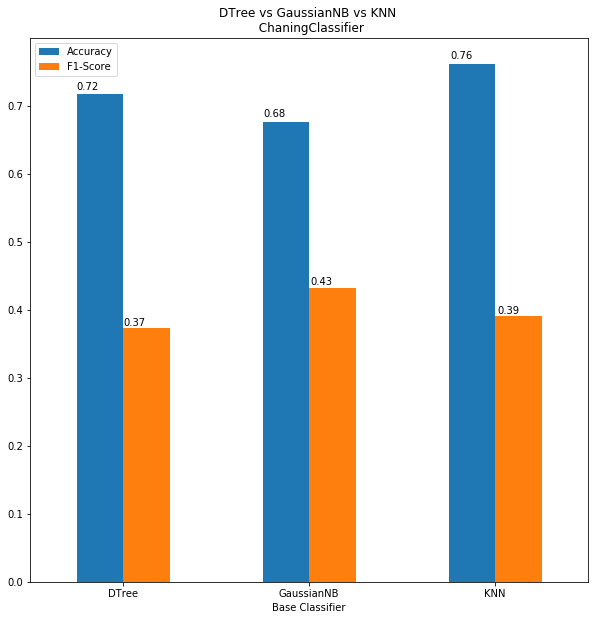

In [0]:
result_df3 = result_df3.set_index(['Base Classifier'])
ax = result_df3.plot.bar(rot=0,title="DTree vs GaussianNB vs KNN \n  ChaningClassifier ",figsize=(10,10))
ax.legend(loc=2)
for p in ax.patches:
    ax.annotate("{0:.2f}".format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.01))

In [0]:
print("BinaryRelevance - under_sampling = FALSE ")
print(result_df1)
print("\n BinaryRelevance - under_sampling = TRUE")
print(result_df2)
print("\n ChainingClassifier")
print(result_df3)

BinaryRelevance - under_sampling = FALSE 
                 Accuracy  F1-Score
Base Classifier                    
DTree            0.727273  0.377213
GaussianNB       0.693477  0.435640
KNN              0.791617  0.386297

 BinaryRelevance - under_sampling = TRUE
                 Accuracy  F1-Score
Base Classifier                    
DTree            0.557851  0.403588
GaussianNB       0.608619  0.437338
KNN              0.664109  0.438019

 ChainingClassifier
                 Accuracy  F1-Score
Base Classifier                    
DTree            0.717090  0.373215
GaussianNB       0.677243  0.432056
KNN              0.761806  0.390414


Checking the <b>computational performance</b> of our algorithms.

In [0]:

# time spent by BinaryRelevance with KNN (Under Sampling False)
start_time = time.time()
br = BinaryRelevanceMLClassifier(classifier=KNeighborsClassifier(n_neighbors=6))
br = br.fit(X_train,Y_train)
br_knn_time = time.time() - start_time
print('BinaryRelevance with KNN (Under Sampling False)\n','Train Time ',"--- %s seconds ---" % (br_knn_time))
y_pred = br.predict(X_test)
br_knn_time = time.time() - start_time
print('Total Time',"--- %s seconds ---" % (br_knn_time),'\n')

# time spent by BinaryRelevance with KNN (Under Sampling True)
start_time = time.time()
br = BinaryRelevanceMLClassifier(classifier=KNeighborsClassifier(n_neighbors=6),use_under_sampling=True)
br = br.fit(X_train,Y_train)
br_us_knn_time = time.time() - start_time
print('BinaryRelevance with KNN (Under Sampling True)\n','Train Time ',"--- %s seconds ---" % (br_us_knn_time))
y_pred = br.predict(X_test)
br_us_knn_time = time.time() - start_time
print('Total Time',"--- %s seconds ---" % (br_us_knn_time),'\n')

# time spent by ChaningClassifier with KNN 
start_time = time.time()
cc = ChaningClassifier(classifier = KNeighborsClassifier(n_neighbors=6))
cc = cc.fit(X_train,Y_train)
cc_knn_time = time.time() - start_time
print('ChaningClassifier with KNN\n','Training Time ',"--- %s seconds ---" % (cc_knn_time))
y_pred = cc.predict(X_test)
cc_knn_time = time.time() - start_time
print('Total Time '"--- %s seconds ---" % (cc_knn_time))


BinaryRelevance with KNN (Under Sampling False)
 Train Time  --- 0.26436543464660645 seconds ---
Total Time --- 3.8976597785949707 seconds --- 

BinaryRelevance with KNN (Under Sampling True)
 Train Time  --- 0.12935233116149902 seconds ---
Total Time --- 1.702263355255127 seconds --- 

ChaningClassifier with KNN
 Training Time  --- 0.29246020317077637 seconds ---
Total Time --- 3.493696689605713 seconds ---


## Conclusion

We were able to get the highest accuracy of 79% using BinaryRelevanceClassifier without under_sampling using base classifier as KNN. But this does not seem to be the best measure because as we use Under Sampling with KNN our F1 score increases from 0.38 to 0.44, which means our precision and recall scores become better by using Under Sampling. 
The time complexity is best for BinaryRelevanceClassifier with under sampling(1.7 sec) which seems obvious as less number of samples take less time for model to be trained on.
One stand out observation is that the total time taken by ChaningClassifier(3.4 sec) is less than even that of a simple BinaryRelevanceClassifier(3.8 sec). Here although the time taken to train the ChaningClassifier is more because we have added computation of appending label to descriptive features, but the time taken to predict is reduced.
